In [174]:
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from os.path import join, isdir, dirname, abspath
from os import listdir
from typing import List
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib as mpl


root_path = dirname(abspath("./"))
import sys
sys.path.append(root_path)

from prochain_transformer.subroutines.eval_sweeps import get_df_recursive, has_logs_subfolder, get_df_kfold_loss

In [175]:
dirpath = "../experiments/training/dx_250602_200_mean_clip_emb_cat/"

In [ ]:
df_loss = get_df_recursive(filepath=dirpath, bottom_action=get_df_kfold_loss, is_bottom= has_logs_subfolder)

loss_label = "val_loss"
sweep_label = "level_3"
base_label = "level_0"
base_columns = ["base_emb","base_model"]

# extract sweeps and base info
df_loss[["sweep_variable", "sweep_value"]] = df_loss[sweep_label].str.extract(r"^(.+)_(\d+)$")
df_loss["sweep_value"] = df_loss["sweep_value"].astype(float)
df_loss[base_columns] = df_loss[base_label].str.extract(r"^emb(\d+)_mod(\d+)$")
df_loss = df_loss.dropna()

# calculate base std
id_vars = df_loss.columns.difference(base_columns).to_list()
df_loss["base_std"] = df_loss.groupby(["sweep_variable","base_emb", "base_model"])[loss_label].transform("std")

# dataframe for heatmaps
df_heat = df_loss[["sweep_variable", "base_emb", "base_model", "base_std"]].drop_duplicates()
df_heat[["base_emb", "base_model"]] = df_heat[["base_emb", "base_model"]].astype(int) 

In [57]:
sample_id = "sweep_dec_pos_emb_hidden" 
df_sub = df_heat[df_heat["sweep_variable"] == sample_id]

max_coord = (df_sub[df_sub["base_std"]==df_sub["base_std"].max()][["base_emb","base_model"]]).values.flatten()
min_coord = (df_sub[df_sub["base_std"]==df_sub["base_std"].min()][["base_emb","base_model"]]).values.flatten()


In [177]:
class DataFrameHeatmapLoader():
    def __init__(
        self, 
        df_heat: pd.DataFrame,
        x_label: str,
        y_label: str,
        values_label: str):
        
        self.df_heat = df_heat
        self.x_label = x_label
        self.y_label = y_label
        self.values_label = values_label
        self.id_variable = "sweep_variable"
        self.lineplot_value_label = "sweep_value"
        self.lineplot_value_vars_labels = ["train_loss","val_loss", "test_loss"]
        self.lineplot_var_name_label = "Loss"
    
    def get_heat_data(self, sample_id: str):
        df_sub = self.df_heat[self.df_heat[self.id_variable] == sample_id]
        x_order = sorted(df_sub[self.x_label].unique())   # ascending
        y_order = sorted(df_sub[self.y_label].unique())   # ascending

        # build the matrix and re-index to those order
        heat = (
            df_sub
            .pivot_table(
                index=self.y_label,
                columns=self.x_label,
                values=self.values_label,
                aggfunc="mean")          # or any reducer you need
            .reindex(index=y_order, columns=x_order)
        )
        return heat
    
    def get_global_min_max(self):
        return self.df_heat[self.values_label].min(), self.df_heat[self.values_label].max()
    
    def get_min_max(self, sample_id: str):
        df_sub = self.df_heat[self.df_heat[self.id_variable] == sample_id]
        max_coord = (df_sub[df_sub[self.values_label]==df_sub[self.values_label]
                            .max()][[self.x_label, self.y_label]]).values.flatten()
        min_coord = (df_sub[df_sub[self.values_label]==df_sub[self.values_label]
                            .min()][[self.x_label, self.y_label]]).values.flatten()
        return max_coord, min_coord
    
    def get_line_data(self, df: pd.DataFrame, sample_id: str ,min_max_flag: str):
        
        array = None
        max_coord, min_coord = self.get_min_max(sample_id)
        
        if min_max_flag == "min":
            array = min_coord.astype(str)
            
        elif min_max_flag == "max":
            array = max_coord.astype(str)
            
        return df.set_index([self.id_variable,self.x_label,self.y_label]
                            ).loc[sample_id].loc[array[0]].loc[array[-1]]
        
        
    def get_line_data_melted(self, df: pd.DataFrame, sample_id: str ,min_max_flag: str):
        
        df = self.get_line_data(df, sample_id, min_max_flag)
        
        return df.melt(
            id_vars=self.lineplot_value_label, 
            value_vars=self.lineplot_value_vars_labels, 
            var_name=self.lineplot_var_name_label)

In [179]:
dataframe_loader = DataFrameHeatmapLoader(
    df_heat=df_heat, 
    x_label="base_emb",
    y_label="base_model",
    values_label="base_std")


vars_list = df_loss["sweep_variable"].unique().tolist()
vars_list = vars_list[:2]

In [180]:
var = vars_list[0]
heat_data = dataframe_loader.get_heat_data(var)
heat_data.at[500,100]

0.007268786127486795

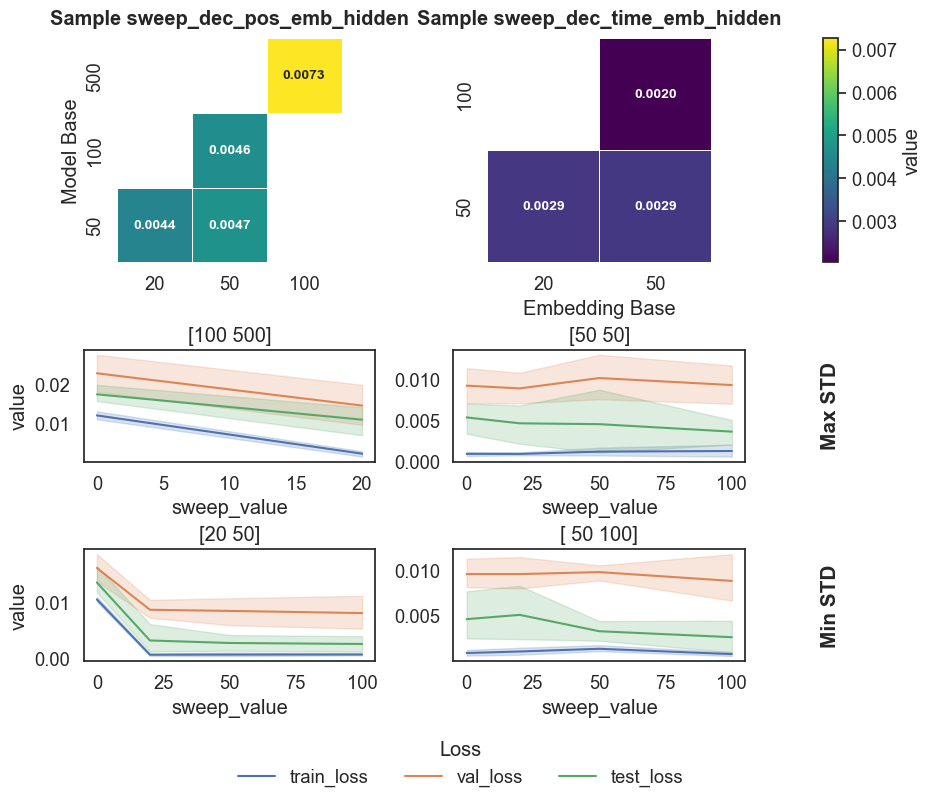

In [181]:



sns.set_theme(style="white", font_scale=1.2)

num_vars = len(vars_list)
fig = plt.figure(figsize=(num_vars*4.6, 8), constrained_layout=True)

gs  = GridSpec(4, 
               num_vars+1, 
               figure=fig,
               width_ratios=[*([1]*num_vars), .05],
               height_ratios=[1, .5, .5, .05])

vmin, vmax = dataframe_loader.get_global_min_max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

for i, var in enumerate(vars_list):
    # ---------- HEAT-MAP ----------
    ax = fig.add_subplot(gs[0, i])

    heat_data = dataframe_loader.get_heat_data(var)
    hm = sns.heatmap(
        heat_data,
        cmap="viridis",
        norm=norm,
        square=True,
        linewidths=.4, linecolor="white",
        cbar=False,          # ← colour-bar removed
        ax=ax,
        annot=True,          # ← show values
        fmt=".4f",           # number format (e.g. 2 decimals)
        annot_kws={"size":10, "weight":"bold"}
    )
    ax.invert_yaxis()
    ax.set_title(f"Sample {var}", pad=10, weight="bold")
    if i: ax.set_ylabel("")
    else: ax.set_ylabel("Model Base")
    if i != num_vars-1: ax.set_xlabel("")
    else: ax.set_xlabel("Embedding Base")

    # --- annotate the max / min cells with their numeric value ---
    max_coord, min_coord = dataframe_loader.get_min_max(sample_id=var)   # (row, col)
    

    # ---------- MAX-line ----------
    ax1 = fig.add_subplot(gs[1, i])
    df_max = dataframe_loader.get_line_data_melted(df_loss, var, "max")
    sns.lineplot(df_max, x="sweep_value", y="value", hue="Loss", ax=ax1)
    ax1.set_title(f"{max_coord}", pad=6)
    if i: ax1.set_ylabel("")
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend().remove()

    # ---------- MIN-line ----------
    ax2 = fig.add_subplot(gs[2, i])
    df_min = dataframe_loader.get_line_data_melted(df_loss, var, "min")
    sns.lineplot(df_min, x="sweep_value", y="value", hue="Loss", ax=ax2)
    ax2.set_title(f"{min_coord}", pad=6)
    if i: ax2.set_ylabel("")
    ax2.legend().remove()

cax = fig.add_subplot(gs[0, -1])          # span only plotting rows
sm  = mpl.cm.ScalarMappable(norm=norm, cmap="viridis")
fig.colorbar(sm, cax=cax, label="value")


ax_tmax = fig.add_subplot(gs[1, -1])
ax_tmax.axis("off")
ax_tmax.text(0.5, 0.5, f"Max STD", ha="center", va="center",
                  fontsize=15, fontweight="bold", rotation="vertical")

ax_tmin = fig.add_subplot(gs[2, -1])
ax_tmin.axis("off")
ax_tmin.text(0.5, 0.5, f"Min STD", ha="center", va="center",
                  fontsize=15, fontweight="bold", rotation="vertical")

ax_leg = fig.add_subplot(gs[-1, :])
ax_leg.axis("off")                          # no ticks / frame

# now draw the legend there
ax_leg.legend(
    handles, labels,
    ncol=len(labels),
    loc="center",
    frameon=False,
    title="Loss",
    borderpad=0.8,            # fine-tune spacing
    handlelength=2.0
)


plt.show()